# Data Process

This notebook covers the extraction and processing of the data used in this project.

All data is collected from [NASA Earth Observations (NEO)](https://neo.gsfc.nasa.gov/about), which hosts various well maintained datasets available for public use.

For demonstration and development purposes, we only show the process for the grayscale GPM_3IMERGDL dataset, which you can read about [here](https://neo.gsfc.nasa.gov/view.php?datasetId=GPM_3IMERGDL). Some code used here is defined in the data module for better portability.

1. [Extract Data](#extract_data)
2. [Exploratory Data Analysis (EDA)](#eda)
3. [Process](#process)

<a id='extract_data'></a>
### Extract Data

In [1]:
from satforecast.data.data import download
from inspect import getsource
from glob import glob

print(getsource(download))

raw_dir = download(verbose='v')
raw_files = sorted(glob(raw_dir + '/*.PNG'))

def download(
    dataset: str = DATASETS['gs_rainfall_daily'],
    years: Iterable[int] = tuple(range(2015, 2021)),
    ext: str ='.PNG',
    force: bool = False,
    verbose='q',
    ) -> str:
    """
    Standardize downloading data

    Parameters
    ----------
    dataset: dataset to download in <type>/<name> format (e.g. rgb or geotiff)
    years: years in dataset to download
    ext: file extension (e.g. .JPEG or .TIFF)
    force: force downloading if dataset already exists
    verbose: verbosity of wget: q (quiet), nv (not verbose), or v (verbose)

    Returns
    -------
    path to saved data
    """

    url = 'https://neo.gsfc.nasa.gov/archive/' + dataset
    save_dir = f'{BASE_DIR}/datasets/{dataset}/raw'

    # \ in triple quotes for os.system
    template = """wget --no-directories --no-host-directories --no-parent \
    --recursive --mirror \
    --accept {accept} \
    -l1 {url}/""" \
    + f""" -P {save_dir} \
    -{verbose}"""

    # Skip if data exists
    if os.pa

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

Use a subset of images for faster EDA.

In [2]:
from skimage.io import imread                                                   
import numpy as np

n_images = 10
eda_files = raw_files[:n_images]

%time eda_images = np.array([imread(f) for f in eda_files])
ref_image = eda_images[0]

CPU times: user 310 ms, sys: 69 ms, total: 379 ms
Wall time: 403 ms


Get basic statistics.

In [3]:
image_size_raw = ref_image.shape

print(f'Raw image size: {image_size_raw}')
print(f'Min pixel value: {ref_image.min()}')
print(f'Max pixel value: {ref_image.max()}')
print(f'Missing values: {np.isnan(ref_image).sum()}')

Raw image size: (1800, 3600)
Min pixel value: 0
Max pixel value: 255
Missing values: 0


The shape is expected as this is a grayscale dataset. The minimum and maximum pixel values are expected given image conventions, but by plotting we can see some values may be misleading.

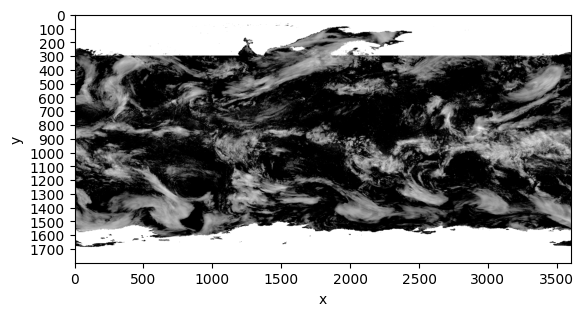

In [4]:
import matplotlib.pyplot as plt

plt.imshow(ref_image, cmap='gray')
plt.xlabel('x')
plt.ylabel('y')

yticks = range(0, image_size_raw[0], 100)
ylabels = [str(i) for i in yticks]
plt.yticks(yticks, ylabels);

The white bands at the top and bottom of the image are not areas of very high precipitation, but areas of unreliable data. As stated in the [description](https://neo.gsfc.nasa.gov/view.php?datasetId=GPM_3IMERGDL), the GPM mission is only expected to measure between 65° north and south latitude, which here corresponds to $300 < y < 1500$. Further, given the complexity of Earth's weather systems we should expect to need years of daliy images to learn the patterns of a fraction of the global map. By cropping in on the north western quadrant, up to $y = 300$, and plotting precipitation over the next few days we should see the effects of northern [westerlies](https://en.wikipedia.org/wiki/Westerlies) and [trade winds](https://en.wikipedia.org/wiki/Trade_winds) over North America, reduce the size of the data, and make the the models' forecasting task easier.

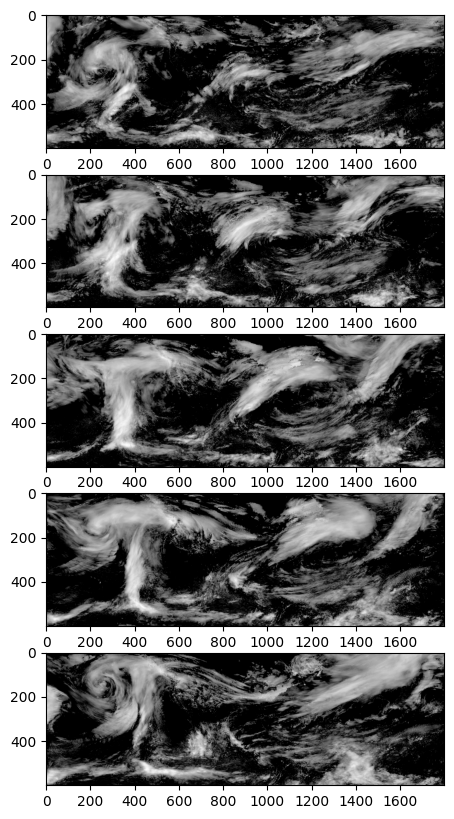

In [5]:
# Crop into north-west quadrant up to 65° (y = 300)
north_lim = 300
south_lim = image_size_raw[0]//2
east_lim = image_size_raw[1]//2
eda_images = eda_images[:, north_lim : south_lim, :east_lim]

n_days = 5
fig, axs = plt.subplots(n_days, 1, figsize=(n_days * 5, 10))

for day in range(1, n_days + 1):
    plt.subplot(n_days, 1, day)
    plt.imshow(eda_images[day], cmap='gray')

We can indeed clearly see the effects of the westerlies. The effects are trade winds are less obvious, but still noticable.

Deep learning models benifit from normalized data, so this should also be done before saving the cropped images. A scaled image is plotted below to ensure there are no unexpected side effects.

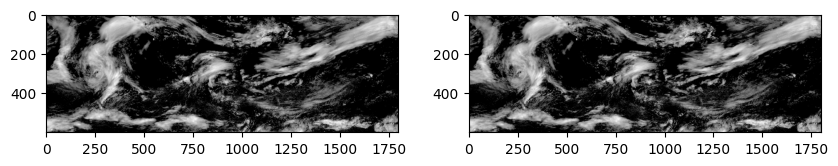

In [6]:
ref_image = eda_images[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Unscaled image
plt.subplot(1, 2, 1)
plt.imshow(ref_image, cmap='gray')

# Scaled image
plt.subplot(1, 2, 2)
plt.imshow(ref_image / 255., cmap='gray');

Note that if you try to open one of these scaled images with a traditional image-viewing program, you will likely see a completley black image.

Before processing all images, let's explore the distribution of precipitation in this region.

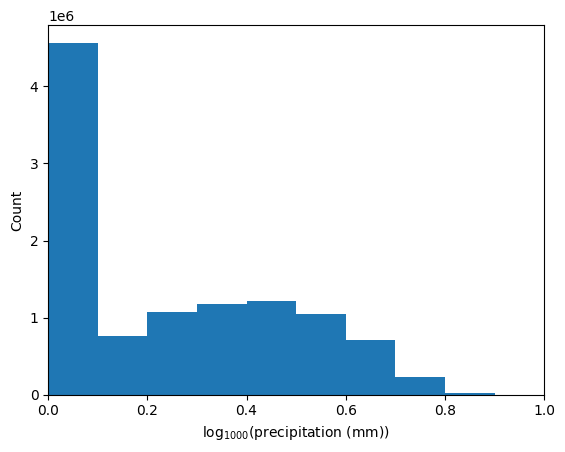

In [7]:
eda_images = eda_images / 255.

plt.hist(eda_images.reshape(np.prod(eda_images.shape)), bins=np.arange(0,1.1,0.1))
plt.xlim((0,1))
plt.xlabel(r'log$_{1000}$(precipitation (mm))')
plt.ylabel('Count');

The distribution makes sense for the most part. The peak at \[0, 0.1) is expected as precipitation is closer to an exception than a rule. In the future, a sparse representation may be benificial, but in any case, the sparse nature of the data must be handled by the model.

<a id='process'></a>
## Process

In [8]:
from satforecast.data.data import process_gs_rainfall_daily

print(getsource(process_gs_rainfall_daily))

%time processed_dir = process_gs_rainfall_daily(force=False)

def process_gs_rainfall_daily(
    force: bool = False,
    n_images: int = None,
    log : int = 100
    ) -> str:
    """
    Perform standard processing for gs_rainfall_daily

    Parameters
    ----------
    force: force processing if processed data already exists
    n_images: number of images to process (used for testing), None indicates all
    log: print every log images, -1 means no logging

    Returns
    -------
    path to processed data
    """

    raw_dir = f"{BASE_DIR}/datasets/{DATASETS['gs_rainfall_daily']}/raw"
    processed_dir = f"{BASE_DIR}/datasets/{DATASETS['gs_rainfall_daily']}/processed"

    # Skip if processed data exists and not reprocessing
    if os.path.exists(processed_dir) and (not force):
        return processed_dir

    # Make processed_dir if it doesn't exist
    os.makedirs(processed_dir, exist_ok=True)

    # Get file paths
    raw_files = get_files(raw_dir, '/*.PNG', n_images)

    # Cropping limits
    image_size_raw = imread(raw_files[0]).sh

With the data being maintained at NEO and the simplifying choices made to facilitate development, processing the data is simple and quick.